In [1]:
from dummy_ads_data import campaigns, ad_groups, metrics

# summarize performance data by campaign
campaign_summary = {}
for campaign in campaigns:
    cid = campaign["id"]
    campaign_summary[cid] = {"name": campaign["name"], "total_clicks": 0, "total_cost": 0}

for metric in metrics:
    ag_id = metric["ad_group_id"]
    # ad_group -> campaign_id
    campaign_id = next(ag["campaign_id"] for ag in ad_groups if ag["id"] == ag_id)
    campaign_summary[campaign_id]["total_clicks"] += metric["clicks"]
    campaign_summary[campaign_id]["total_cost"] += metric["cost"]

# print summary
for cid, data in campaign_summary.items():
    print(f"Campaign '{data['name']}': Clicks={data['total_clicks']}, Cost=${data['total_cost']:.2f}")


Campaign 'App Install - IOS': Clicks=3887, Cost=$1559.52
Campaign 'App Install - Android': Clicks=3660, Cost=$1182.59
Campaign 'Retargeting Campaign': Clicks=2064, Cost=$534.16


In [2]:
import pandas as pd

# convert to dataframe
df_summary = pd.DataFrame.from_dict(campaign_summary, orient="index")

df_summary

,name,total_clicks,total_cost
1,App Install - IOS,3887,1559.52
2,App Install - Android,3660,1182.59
3,Retargeting Campaign,2064,534.16


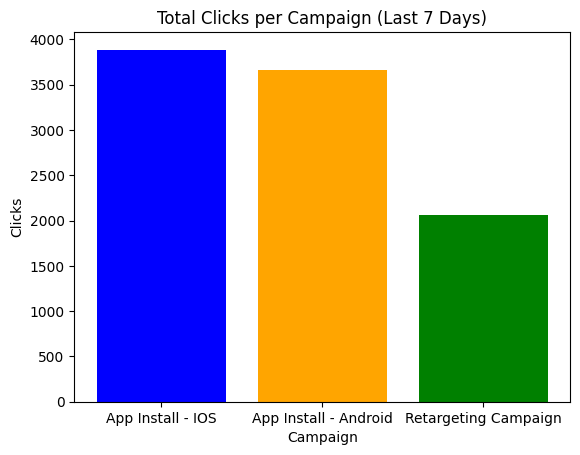

In [9]:
import matplotlib.pyplot as plt

plt.bar(df_summary["name"], df_summary["total_clicks"], color=["blue", "orange", "green"])
plt.title("Total Clicks per Campaign (Last 7 Days)")
plt.xlabel("Campaign")
plt.ylabel("Clicks")
plt.show()

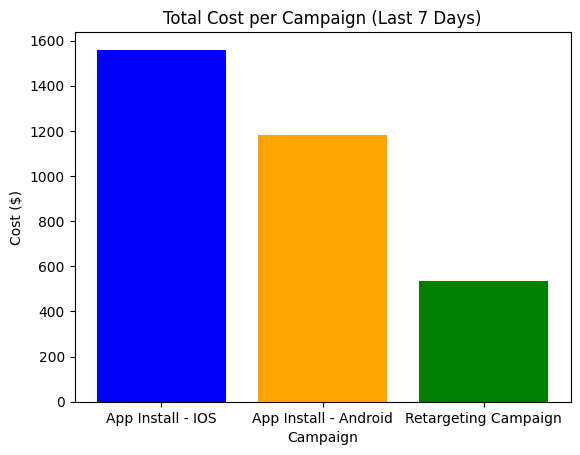

In [10]:
plt.bar(df_summary["name"], df_summary["total_cost"], color=["blue", "orange", "green"])
plt.title("Total Cost per Campaign (Last 7 Days)")
plt.xlabel("Campaign")
plt.ylabel("Cost ($)")
plt.show()

In [12]:
df_metrics = pd.DataFrame(metrics)

# join ad_group -> campaign
df_ad_groups = pd.DataFrame(ad_groups)
df_campaigns = pd.DataFrame(campaigns)

# merge ad_group into metrics
df = df_metrics.merge(df_ad_groups[["id", "campaign_id"]], left_on="ad_group_id", right_on="id")
df = df.merge(df_campaigns[["id", "name"]], left_on="campaign_id", right_on="id", suffixes=("_adgroup", "_campaign"))

# date column as datetime
df["date"] = pd.to_datetime(df["date"])
df.head()

,ad_group_id,date,impressions,clicks,cost,conversions,installs,revenue,id_adgroup,campaign_id,id_campaign,name
0,101,2025-09-01,2921,82,111.98,53,55,120.22,101,1,1,App Install - IOS
1,101,2025-09-02,2687,348,154.67,33,34,83.57,101,1,1,App Install - IOS
2,101,2025-09-03,4653,212,133.44,82,85,403.16,101,1,1,App Install - IOS
3,101,2025-09-04,1198,284,110.18,16,15,66.91,101,1,1,App Install - IOS
4,101,2025-09-05,1122,326,53.33,46,49,85.74,101,1,1,App Install - IOS


In [31]:
df_daily = df.groupby(["date", "name"]).agg({
    "impressions": "sum",
    "clicks": "sum",
    "cost": "sum",
    "conversions": "sum",
    "installs": "sum",
    "revenue": "sum"
}).reset_index()
df_daily.head()

,date,name,impressions,clicks,cost,conversions,installs,revenue
0,2025-09-01,App Install - Android,6213,614,128.28,111,111,363.65
1,2025-09-01,App Install - IOS,4206,351,275.75,138,139,442.31
2,2025-09-01,Retargeting Campaign,4881,406,133.65,65,62,258.25
3,2025-09-02,App Install - Android,8048,621,199.40,111,111,469.29
4,2025-09-02,App Install - IOS,7033,698,297.73,88,87,335.88


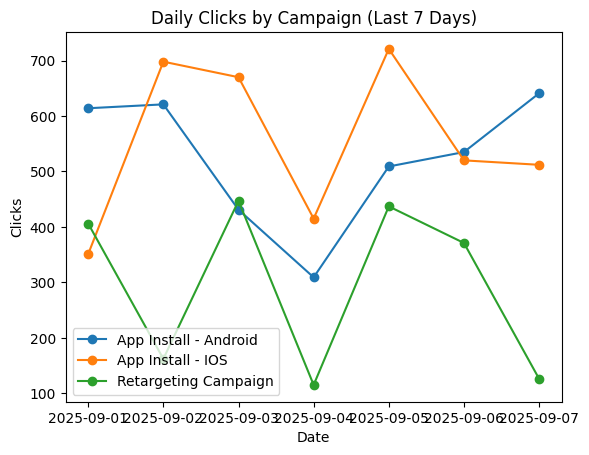

In [32]:
for campaign_name in df_daily["name"].unique():
    subset = df_daily[df_daily["name"] == campaign_name]
    plt.plot(subset["date"], subset["clicks"], marker="o", label=campaign_name)

plt.title("Daily Clicks by Campaign (Last 7 Days)")
plt.xlabel("Date")
plt.ylabel("Clicks")
plt.legend()
plt.show()

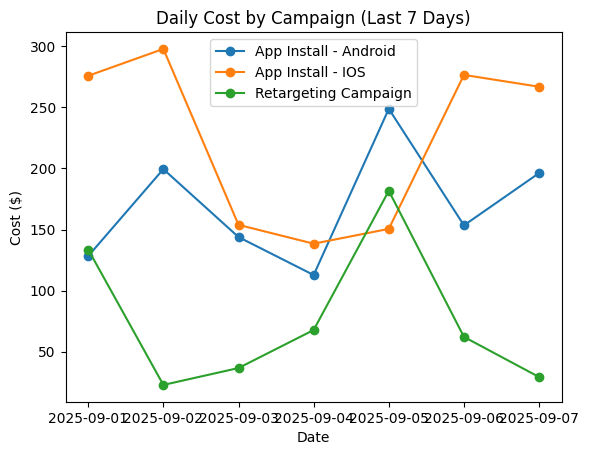

In [21]:
for campaign_name in df_daily["name"].unique():
    subset = df_daily[df_daily["name"] == campaign_name]
    plt.plot(subset["date"], subset["cost"], marker="o", label=campaign_name)

plt.title("Daily Cost by Campaign (Last 7 Days)")
plt.xlabel("Date")
plt.ylabel("Cost ($)")
plt.legend()
plt.show()

#### Calculate KPIs
* CTR (Click-through Rate) = clicks / impressions
* CPC (Cost per Click) = cost / clicks
* CPA (Cost per Acquisition) = cost / conversions
* ROAS (Return on Ad Spend) = revenue / cost
* CR (Conversion Rate) = conversions / clicks

In [ ]:
# calculate additional metrics
df_daily["CTR"] = df_daily["clicks"] / df_daily["impressions"].replace(0, pd.NA)
df_daily["CPC"] = df_daily["cost"] / df_daily["clicks"].replace(0, pd.NA)
df_daily["CPA"] = df_daily["cost"] / df_daily["conversions"].replace(0, pd.NA)
df_daily["ROAS"] = df_daily["revenue"] / df_daily["cost"].replace(0, pd.NA)
df_daily["CR"] = df_daily["conversions"] / df_daily["clicks"].replace(0, pd.NA)

df_daily.head()

,date,name,impressions,clicks,cost,conversions,installs,revenue,CTR,CPC,CPA,ROAS,CR
0,2025-09-01,App Install - Android,6213,614,128.28,111,111,363.65,0.098825,0.208925,1.155676,2.834814,0.180782
1,2025-09-01,App Install - IOS,4206,351,275.75,138,139,442.31,0.083452,0.785613,1.998188,1.604025,0.393162
2,2025-09-01,Retargeting Campaign,4881,406,133.65,65,62,258.25,0.083180,0.329187,2.056154,1.932286,0.160099
3,2025-09-02,App Install - Android,8048,621,199.40,111,111,469.29,0.077162,0.321095,1.796396,2.353511,0.178744
4,2025-09-02,App Install - IOS,7033,698,297.73,88,87,335.88,0.099246,0.426547,3.383295,1.128136,0.126074


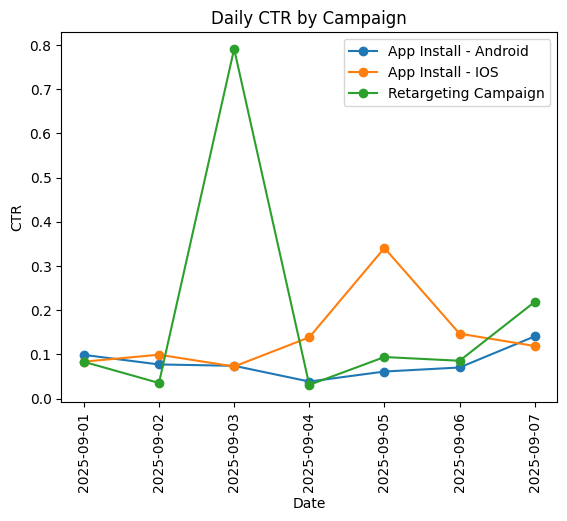

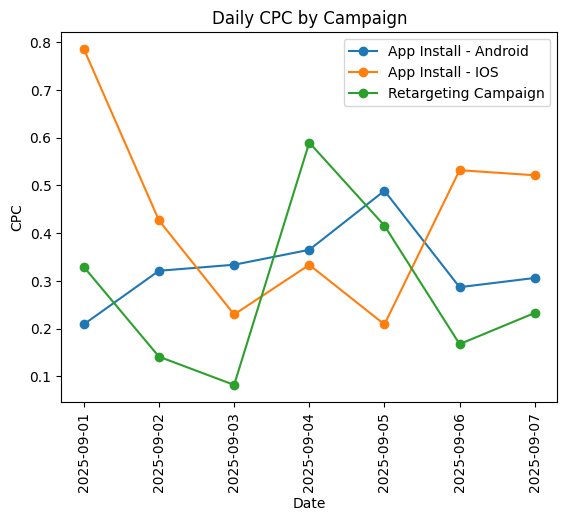

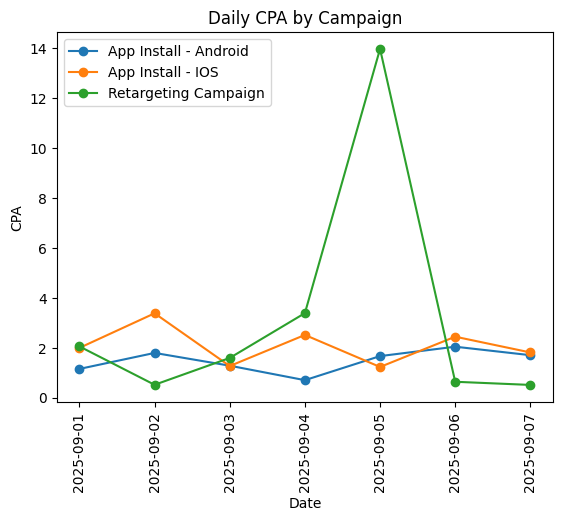

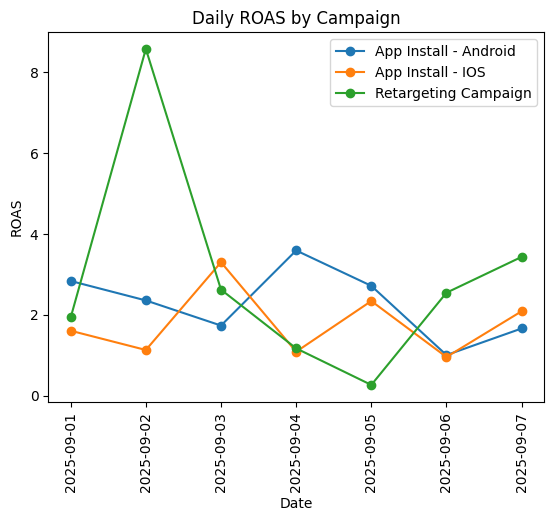

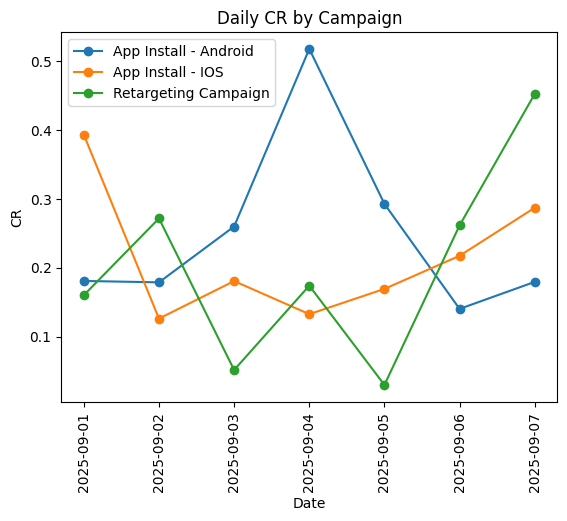

In [36]:
# plot KPIs
kpis = ["CTR", "CPC", "CPA", "ROAS", "CR"]

for kpi in kpis:
    for campaign_name in df_daily["name"].unique():
        subset = df_daily[df_daily["name"] == campaign_name]
        plt.plot(subset["date"], subset[kpi], marker="o", label=campaign_name)

    plt.title(f"Daily {kpi} by Campaign")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    plt.ylabel(kpi)
    plt.legend()
    plt.show()